# `HM-OT` on synthetic data: Langevin dynamics on 2d-Waddington landscape

## imports

### mount drive

In [1]:
# if needed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### pip installs

In [2]:
!pip install scanpy moscot ott-jax diffrax napari anndata -q
!pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

### imports

In [3]:
import sys
import os
import random
import importlib

import pandas as pd
from anndata import AnnData
import scanpy as sc

import random
import numpy as np
import torch

from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans

# import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from PIL import Image

import jax
import jax.numpy as jnp
from jax import random as jax_random
import moscot as mt
import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

### import `HM-OT`

In [9]:
fh_hmot = 'drive/Othercomputers/numac/GitHub/HM-OT/' # filehandle for HM-OT

sys.path.insert(0, filehandle_hmot)

import src.FRLC as FRLC
import src.FRLC.FRLC_multimarginal as FRLC_multimarginal
import src.HiddenMarkovOT as HiddenMarkovOT

import src.utils.clustering as clustering
import src.utils.util_LR as util_LR
import src.utils.util_zf as util_zf

from src.utils.util_LR import convert_adata
from src.utils.waddington import viewer, visual, minima, simulation, differentiation, metrics
from src.utils.waddington import seed_everything
from src.platting import color_utils, palette_utils, string_utils, spatial_scatter, diffmap, sankey
# import src.plotting as plotting
import experiments.differentiation_map_validation as dmv # for cosine similarity


## set seed

In [5]:
# Set global seed for reproducibility
GLOBAL_SEED = 42
# np.random.seed(GLOBAL_SEED)
seed = seed_everything(GLOBAL_SEED)

🌱 Setting global seed to 42
  ✓ PyTorch + CUDA seeded
  ✓ JAX PRNG key created
🌱 All available RNGs seeded.


## settings

### reload / set `device`, `dtype`

In [6]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(HiddenMarkovOT)
importlib.reload(dmv)

<module 'experiments.differentiation_map_validation' from '/content/drive/Othercomputers/numac/GitHub/HM-OT/experiments/differentiation_map_validation.py'>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float32

On device: cuda


## set parameters (`TIMEPOINTS`, `ASSIGNMENT_RADIUS`, `LANGEVIN` parameters)

In [8]:
%%time
# timepoint indices of snapshots of Langevin dynamics
TIMEPOINTS = [19, 42, 1100] # snapshots taken at these timepoints

# assignment radius (determines cell type assignments):
ASSIGNMENT_RADIUS = 1.6

# Langevin dynamics parameteters
LANGEVIN_n_particles = 1000 # number of partciles
LANGEVIN_N_timesteps = 1500 # number of time steps
LANGEVIN_dt = 0.2
LANGEVIN_D = 0.008

SHOW_DYN = False # Set to True to visualize dynamics with napari
# ------------------------------------------------------------------
if __name__ == "__main__" and SHOW_DYN:
    try:
        viewer.launch_viewer_with_differentiation(
            timepoints=TIMEPOINTS,
            langevin_n=LANGEVIN_n_particles,
            langevin_N=LANGEVIN_N_timesteps,
            langevin_dt=LANGEVIN_dt,
            langevin_D=LANGEVIN_D,
            assignment_radius=ASSIGNMENT_RADIUS)
        napari.run()
    except Exception as e:
        print("Napari error:", e)
        print("Install with: pip install 'napari[all]' scipy")

CPU times: user 12 µs, sys: 2 µs, total: 14 µs
Wall time: 18.8 µs


## landscape, notion of cell type

instead of running napari in-notebook (code for this is below), see the notebook `waddington_data_viz.ipynb`.

Assignment radius: 1.6
Verification (polar coords):
(-1.554, -2.692)  r= 3.11  θ= 240.0° → A240
( 3.108,  0.000)  r= 3.11  θ=   0.0° → A0
(-1.554,  2.692)  r= 3.11  θ= 120.0° → A120
(-0.018, -5.586)  r= 5.59  θ= 269.8° → B270
(-0.018,  5.586)  r= 5.59  θ=  90.2° → B90
(-4.829, -2.809)  r= 5.59  θ= 210.2° → B210
(-4.829,  2.809)  r= 5.59  θ= 149.8° → B150
( 4.847, -2.777)  r= 5.59  θ= 330.2° → B330
( 4.847,  2.777)  r= 5.59  θ=  29.8° → B30
(-0.000, -8.924)  r= 8.92  θ= 270.0° → C270
(-0.000,  8.924)  r= 8.92  θ=  90.0° → C90
( 7.729, -4.462)  r= 8.92  θ= 330.0° → C330
( 7.729,  4.462)  r= 8.92  θ=  30.0° → C30
(-7.729, -4.462)  r= 8.92  θ= 210.0° → C210
(-7.729,  4.462)  r= 8.92  θ= 150.0° → C150


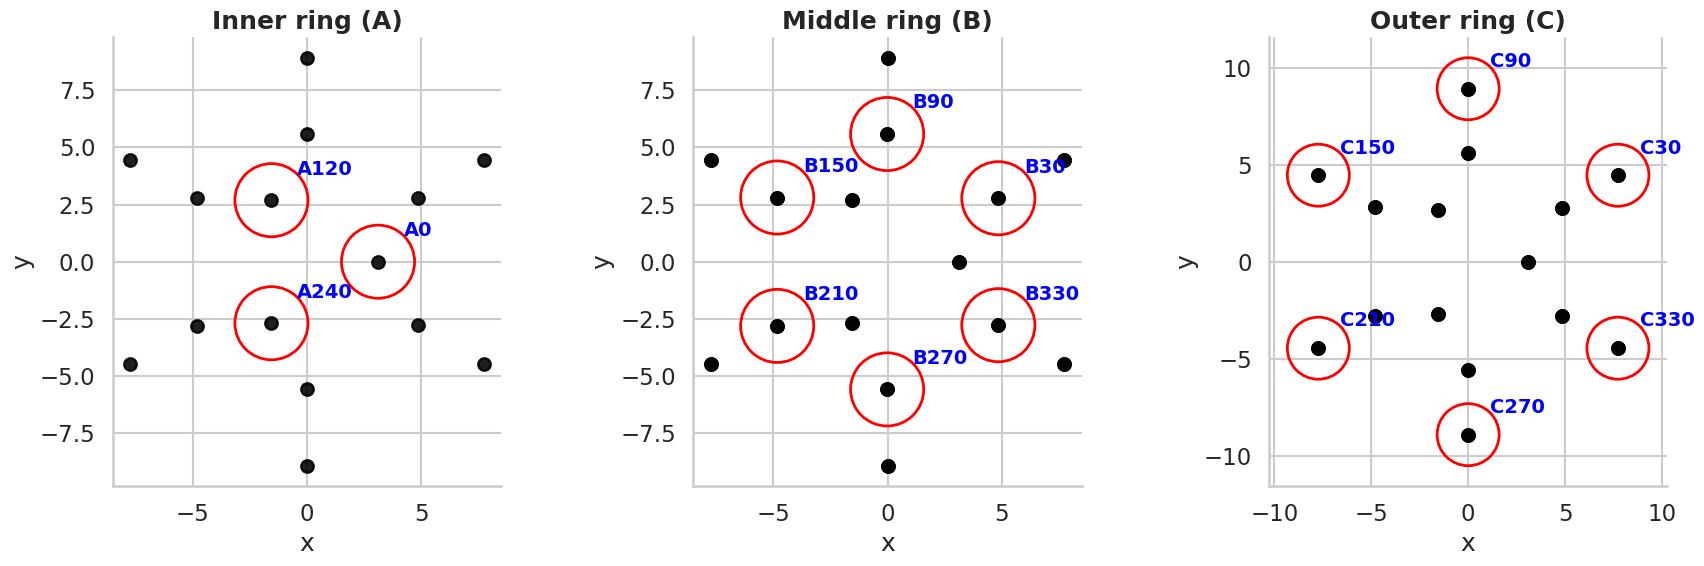


Total clusters: 15


In [10]:
MINIMA_POINTS = minima.find_local_minima()
# local minima of the Waddington landscape
# (+ ASSIGNMENT_RADIUS) determine cell type
cluster_dict = visual.create_cluster_dict_and_plot(
    MINIMA_POINTS,
    ASSIGNMENT_RADIUS)

## run Langevin dynamics to get trajectory data without any measurement noise

In [11]:
# snapshots = dynamics snapshots at each timepoint
Xs, Ys, snapshots = simulation.simulate_langevin_with_snapshots(
    n_particles=LANGEVIN_n_particles,
    n_steps=LANGEVIN_N_timesteps,
    dt=LANGEVIN_dt,
    diffusion=LANGEVIN_D,
    snap_times=TIMEPOINTS)

transition_maps, cell_assignments, type_labels = differentiation.build_differentiation_map(
    Xs, Ys, MINIMA_POINTS,
    timepoints=TIMEPOINTS,
    assignment_radius=ASSIGNMENT_RADIUS
)
keys = [f"t{TIMEPOINTS[0]}_to_t{TIMEPOINTS[1]}", f"t{TIMEPOINTS[1]}_to_t{TIMEPOINTS[2]}"]
matrices = [transition_maps[key] for key in keys]
dfs = [pd.DataFrame(mat, index=type_labels, columns=type_labels) for mat in matrices]

## ground truth cell type assignment

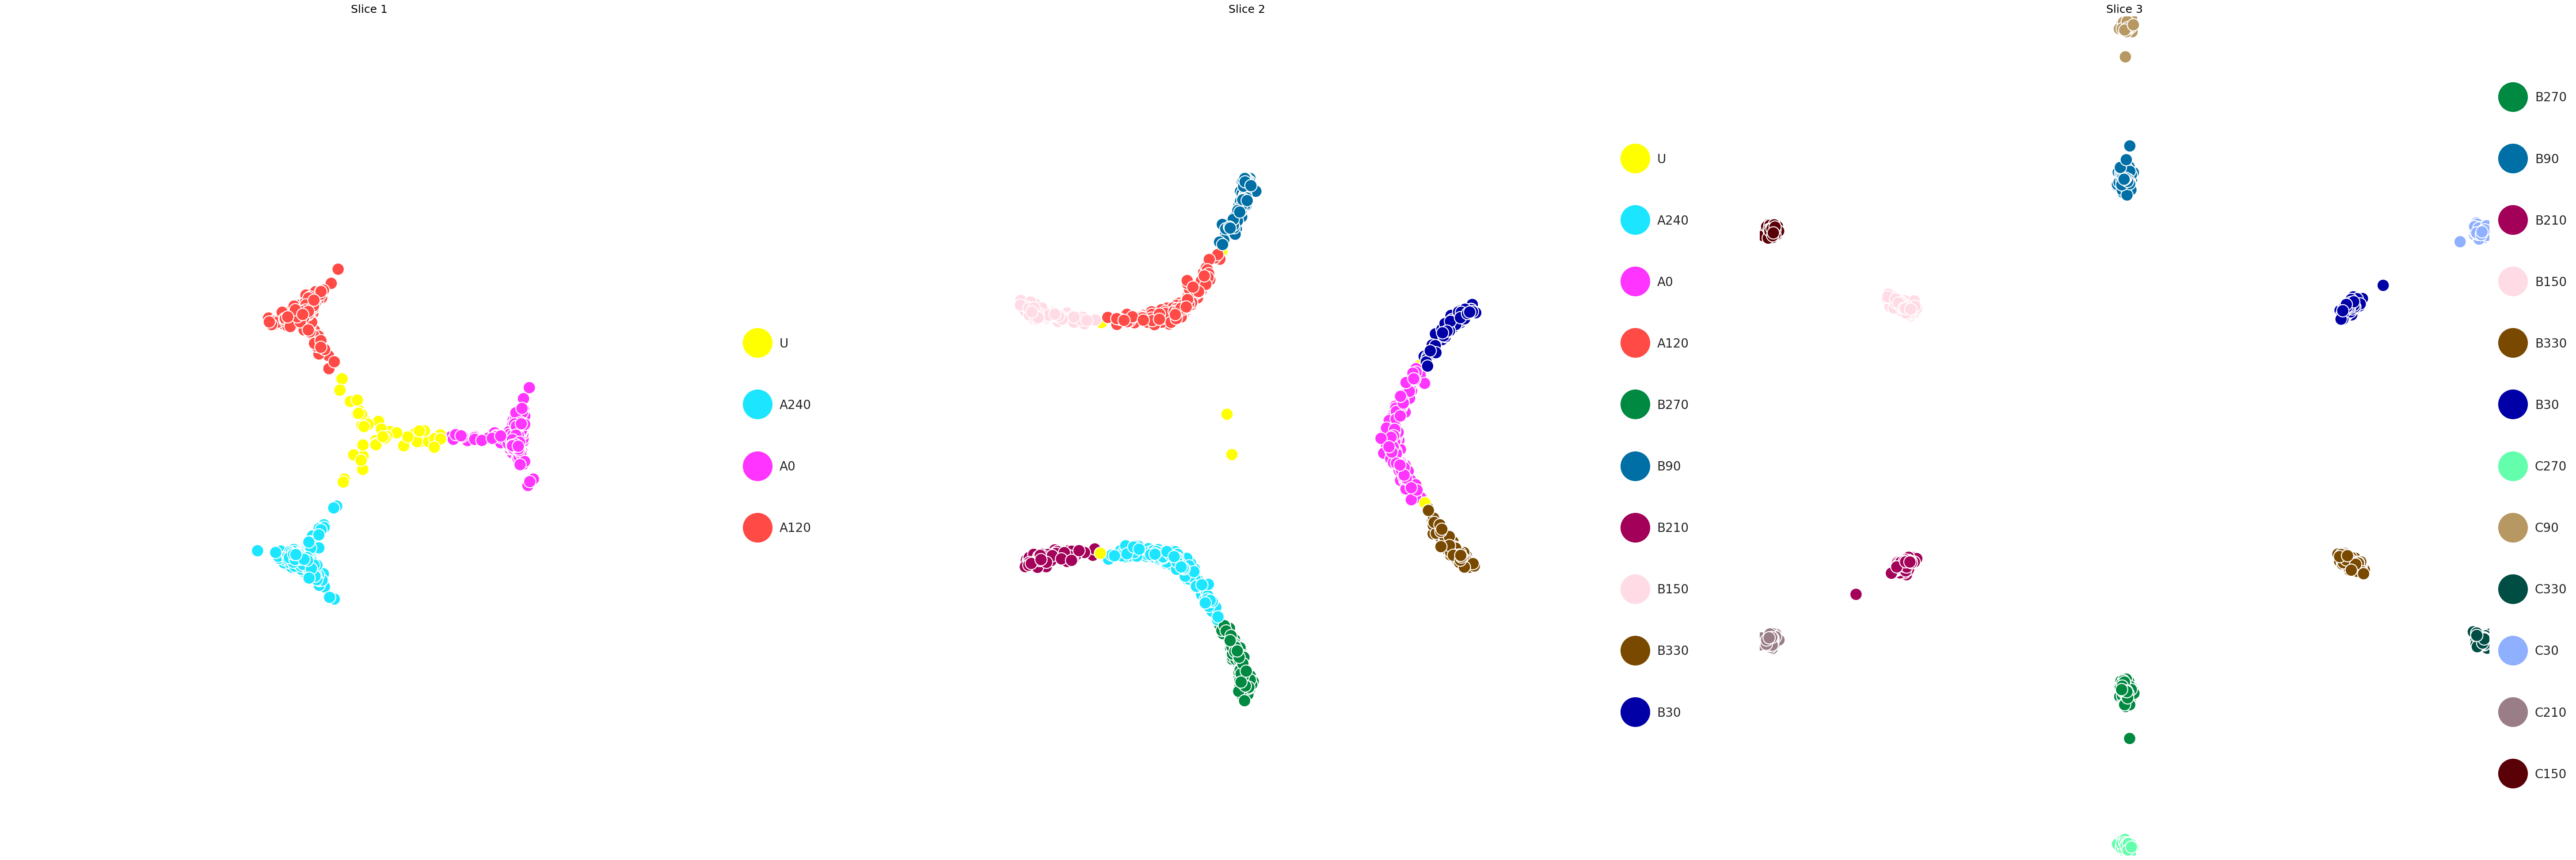

In [12]:
Ss = [
    np.stack((Xs[:, t], Ys[:, t]), axis=1)     # shape (N, 2)
    for t in TIMEPOINTS
]

Qs_gt_full =  minima.build_Qs(Ss, MINIMA_POINTS, ASSIGNMENT_RADIUS)

if GLOBAL_SEED == 42 and TIMEPOINTS == [19, 42, 1100]:
    cell_type_labels_t1 = ['U','A240', 'A0', 'A120']
    cell_type_labels_t2 = ['U', 'A240', 'A0', 'A120', 'B270', 'B90', 'B210', 'B150', 'B330', 'B30']
    cell_type_labels_t3 = ['B270', 'B90', 'B210', 'B150', 'B330', 'B30', 'C270', 'C90', 'C330', 'C30', 'C210', 'C150']
    cell_type_labels = [cell_type_labels_t1, cell_type_labels_t2, cell_type_labels_t3]

spatial_scatter.plot_clusters_from_QT(
    Qs = Qs_gt_full,
    Ts = [None, None],
    Ss=Ss,
    cell_type_labels=cell_type_labels,
    dotsize=400.0,
    key_dotsize=1.0,
    global_Qs=True)

## set params for experiment: range and number of noise levels

In [15]:
STD=0.6
NOISE_min = 0.5 * STD
NOISE_max = 2.0 * STD
n_TIMEPOINTS = len(TIMEPOINTS)

n_noise_levels = 2
noise_level_range = np.linspace(NOISE_min, NOISE_max, n_noise_levels)


# Shape: (n_noise_levels, n_timepoints, n_particles, 2)
all_matrices = np.random.normal(0, 1, size=(n_noise_levels, n_TIMEPOINTS, LANGEVIN_n_particles, 2))

# Scale by noise levels
matrices = {}
for i, level in enumerate(noise_level_range):
    matrices[level] = [all_matrices[i, t] * level for t in range(n_TIMEPOINTS)]

matrix_list = list(matrices.values()) # list, indexed implicitly by noise level
print(f"shape of matrices: {np.array(matrix_list[0]).shape}")

if GLOBAL_SEED == 42 and TIMEPOINTS == [19, 42, 1100]:
    cell_type_labels_t1 = ['U','A240', 'A0', 'A120']
    cell_type_labels_t2 = ['U', 'A240', 'A0', 'A120', 'B270', 'B90', 'B210', 'B150', 'B330', 'B30']
    cell_type_labels_t3 = ['B270', 'B90', 'B210', 'B150', 'B330', 'B30', 'C270', 'C90', 'C330', 'C30', 'C210', 'C150']
    cell_type_labels = [cell_type_labels_t1, cell_type_labels_t2, cell_type_labels_t3]

for i, level in enumerate(noise_level_range):
    print(f'noise level {i} / {len(noise_level_range)}: {level}')
    Ss_noisy = [ S + matrices[level][t] for t, S in enumerate(Ss) ]
    spatial_scatter.plot_clusters_from_QT(
        Qs = Qs_gt_full,
        Ts = [None, None],
        Ss=Ss_noisy,
        cell_type_labels=cell_type_labels,
        dotsize=400.0,
        key_dotsize=1.0,
        global_Qs=True)

Output hidden; open in https://colab.research.google.com to view.

## experiment loop

In [ ]:
%%time
# ────────────────────────────────────────────────────────────────────────────────
# initialize lists for storing output
wot_ami_list = []
wot_ari_list = []
hmot_ami_list = []
hmot_ari_list = []

hmot_cos_scores = []
wot_cos_scores = []

for level in noise_level_range:
    print(f"noise level = {level}")
    # ────────────────────────────────────────────────────────────────────────────────
    # generate data, ground truth objects
    X, time_labels, cluster_labels, lineage = generate_branching_blobs(n_per_cluster=n_per_cluster_og,
                                                                       std=std,
                                                                       random_seed=random_state,
                                                                       CS=cs)

    Qs_gt = Qs_gt #[ Q / 999.0 for Q in Qs_gt_ ]
    # ────────────────────────────────────────────────────────────────────────────────
    # plotting data by timepoint
    print(f"plotting data by timepoint, for CS = {cs}")
    df = pd.DataFrame({
    "x": X[:, 0],
    "y": X[:, 1],
    "timepoint": time_labels
    })

    palette = sns.color_palette("husl", n_colors=df["timepoint"].nunique())

    fig, ax = plt.subplots(figsize=(FIGSIZE, FIGSIZE))
    sns.scatterplot(
        data=df,
        x="x", y="y",
        hue="timepoint",
        palette=palette,
        s=60,
        linewidth=0.3, edgecolor="k",
        ax=ax
    )

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.legend(title="timepoint", bbox_to_anchor=(1.02, 1), loc="upper left")
    sns.despine()
    plt.tight_layout()
    plt.show()


    # ────────────────────────────────────────────────────────────────────────────────
    # separate data into timepoints
    X1 = X[time_labels == 0]
    X2 = X[time_labels == 1]
    X3 = X[time_labels == 2]
    Ss = [X1, X2, X3]

    # ────────────────────────────────────────────────────────────────────────────────
    # plotting data by ground truth cluster
    print(f"plotting data by ground truth cluster, for CS = {cs}")
    labels1_gt_ = np.argmax(Qs_gt[0], axis=1)
    labels2_gt_ = np.argmax(Qs_gt[1], axis=1)
    labels3_gt_ = np.argmax(Qs_gt[2], axis=1)

    labels1_gt = labels1_gt_
    labels2_gt = labels2_gt_ + len(set(labels1_gt))
    labels3_gt = labels3_gt_ + len(set(labels1_gt)) + len(set(labels2_gt))

    gt_clustering_list = [labels1_gt, labels2_gt, labels3_gt]
    '''
    plotting.plot_all_sc_clusters(spatial_list=Ss,
                                clustering_list=gt_clustering_list,
                                dotsize=100)
    ''';

    # ────────────────────────────────────────────────────────────────────────────────
    # compute k-means objects
    kmeans1 = kmeans = KMeans(n_clusters=3,
                          random_state=random_state)
    kmeans2 = kmeans = KMeans(n_clusters=6,
                            random_state=random_state)
    kmeans3 = kmeans = KMeans(n_clusters=6,
                            random_state=random_state)

    klabels1_ = kmeans1.fit_predict(X1)
    klabels2_ = kmeans2.fit_predict(X2)
    klabels3_ = kmeans3.fit_predict(X3)

    klabels1 = klabels1_
    klabels2 = klabels2_ + len(set(klabels1))
    klabels3 = klabels3_ + len(set(klabels1)) + len(set(klabels2))

    Q1_ann = np.eye(len(set(klabels1_)))[klabels1_]
    Q2_ann = np.eye(len(set(klabels2_)))[klabels2_]
    Q3_ann = np.eye(len(set(klabels3_)))[klabels3_]
    Qs_ann = [Q1_ann, Q2_ann, Q3_ann]

    cell_type_labels = np.concatenate([klabels1, klabels2, klabels3])

    # ────────────────────────────────────────────────────────────────────────────────
    # visualize k-means clusters
    print(f"k-means clusters for CS = {cs}")
    '''
    plotting.plot_all_sc_clusters(spatial_list=Ss,
                              clustering_list=[klabels1, klabels2, klabels3],
                              dotsize=100)
    ''';

    # ────────────────────────────────────────────────────────────────────────────────
    # compute HM-OT objects
    print(f"making HM-OT cost matrices for CS = {cs}")
    C_factors_sequence = []

    for timepoint in range(2):
        tp1 = X[time_labels == timepoint]
        tp2 = X[time_labels == timepoint+1]
        _X1 = torch.from_numpy(tp1).type(torch.DoubleTensor).to(device)
        _X2 = torch.from_numpy(tp2).type(torch.DoubleTensor).to(device)
        C12 = torch.cdist(_X1, _X2).to(device)
        C12 = C12.to(dtype)
        I = torch.eye(C12.shape[1]).to(dtype).to(device)
        C_factors_sequence.append(( C12, I ))
    # ────────────────────────────────────────────────────────────────────────────────
    # set HM-OT parameters
    rank_list = [(3,6), (6,6)]
    iter = 100
    gamma = 120.0
    alpha = 0.0
    tau_in = 1e5
    # ────────────────────────────────────────────────────────────────────────────────
    # run HM-OT
    print(f"running HM-OT for CS = {cs}")
    hmot = HiddenMarkovOT.HM_OT(rank_list = rank_list,
                                max_iter = iter,
                                min_iter = iter,
                                device=device,
                                alpha = alpha,
                                gamma = gamma,
                                dtype = dtype,
                                printCost = False,
                                returnFull = False,
                                initialization = 'Full',
                                tau_in = tau_in,
                                proportions=proportions_tens,
                                )

    A_factors_sequence = [None] * (n_timepoints)
    hmot.gamma_smoothing(C_factors_sequence,
                        A_factors_sequence)

    # ────────────────────────────────────────────────────────────────────────────────
    # extract HM-OT objects
    Qs = hmot.Q_gammas
    Ts = hmot.T_gammas

    Qs_np = [Q.cpu().detach().numpy() for Q in Qs]
    Ts_np = [T.cpu().detach().numpy() for T in Ts]

    hmot_labels1_ = np.argmax(Qs_np[0], axis=1)
    hmot_labels2_ = np.argmax(Qs_np[1], axis=1)
    hmot_labels3_ = np.argmax(Qs_np[2], axis=1)

    hmot_labels1 = hmot_labels1_
    hmot_labels2 = hmot_labels2_ + len(set(hmot_labels1))
    hmot_labels3 = hmot_labels3_ + len(set(hmot_labels1)) + len(set(hmot_labels2))

    hmot_clustering_list = [hmot_labels1, hmot_labels2, hmot_labels3]
    # ────────────────────────────────────────────────────────────────────────────────
    # plot HM-OT clusters
    print(f"plotting HM-OT clusters for CS = {cs}")
    plotting.plot_all_sc_clusters(spatial_list=Ss,
                              clustering_list=hmot_clustering_list,
                              dotsize=100)
    # ────────────────────────────────────────────────────────────────────────────────
    # plot HM-OT diffmap
    print(f"plotting HM-OT diffmap for CS = {cs}")
    plotting.diffmap_from_QT(Qs_np, Ts_np)

    # ────────────────────────────────────────────────────────────────────────────────
    # setup data for W-OT
    adata_12 = setup_point_clouds_for_waddington_ot(X1,
                                                X2,
                                                ct_labels_1=klabels1,
                                                ct_labels_2=klabels2)
    adata_12.obs["celltype"] = adata_12.obs["celltype"].astype("category")
    adata_23 = setup_point_clouds_for_waddington_ot(X2,
                                                    X3,
                                                    ct_labels_1=klabels2,
                                                    ct_labels_2=klabels3)
    adata_23.obs["celltype"] = adata_23.obs["celltype"].astype("category")
    tp_12 = mt.problems.time.TemporalProblem(adata_12)
    tp_23 = mt.problems.time.TemporalProblem(adata_23)

    tp_12.prepare(time_key='time_point')
    tp_23.prepare(time_key='time_point')

    solve_kwargs = {
        'epsilon': 0.05,
        'tau_a': 1.0,
        'tau_b': 1.0,
    }
    # ────────────────────────────────────────────────────────────────────────────────
    # running W-OT
    print(f"running W-OT for CS = {cs}")
    tp_12.solve(**solve_kwargs)
    pi_12 = tp_12.solutions[(0, 1)].transport_matrix
    tp_23.solve(**solve_kwargs)
    pi_23 = tp_23.solutions[(0, 1)].transport_matrix

    # ────────────────────────────────────────────────────────────────────────────────
    # make transitions from W-OT
    print(f"making transitions from W-OT for CS = {cs}")
    tp_12.cell_transition(source = 0,
                      target = 1,
                      source_groups="celltype",
                      target_groups="celltype",
                      forward=True,
                      key_added="cell_transition"
                )

    tm = adata_12.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']

    tm_ordered = tm.loc[np.unique(klabels1), np.unique(klabels2)]
    T12_ = tm_ordered.to_numpy()
    Q1 = Qs_ann[0] / Qs_ann[0].sum()
    T12 = np.diag(np.sum(Q1, axis=0)) @ T12_

    tp_23.cell_transition(source = 0,
                        target = 1,
                        source_groups="celltype",
                        target_groups="celltype",
                        forward=True,
                        key_added="cell_transition"
                    )

    tm = adata_23.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']

    tm_ordered = tm.loc[np.unique(klabels2), np.unique(klabels3)]
    T23_ = tm_ordered.to_numpy()
    Q2 = Qs_ann[1] / Qs_ann[1].sum()
    T23 = np.diag(np.sum(Q2, axis=0)) @ T23_

    Ts_wot = [T12, T23]
    # ────────────────────────────────────────────────────────────────────────────────
    # plot W-OT diffmap
    print(f"plotting W-OT diffmap for CS = {cs}")
    plotting.diffmap_from_QT(Qs_ann, Ts_wot)

    # ────────────────────────────────────────────────────────────────────────────────
    # plotting overlayed diffmaps for each method
    ## first: HM-OT
    print(f"plotting overlayed diffmap for HM-OT, with CS = {cs}")
    fig, ax = plotting.plot_diffmap_clusters_prime(
        X,                   # your (N×2) point‐cloud
        time_labels,         # length-N array of 0,1,2…
        Qs_np,               # list of factor matrices Qs_np[t]: (n_t × k_t)
        Ts_np,               # list of transition matrices Ts_np[t]: (k_t × k_{t+1})
        df,                  # your DataFrame with “x”,”y”,”timepoint” columns
    )

    plt.show()
    ## second: W-OT
    print(f"plotting overlayed diffmap for W-OT, with CS = {cs}")
    fig, ax = plotting.plot_diffmap_clusters_prime(
        X,                   # your (N×2) point‐cloud
        time_labels,         # length-N array of 0,1,2…
        Qs_ann,               # list of factor matrices Qs_np[t]: (n_t × k_t)
        Ts_wot,               # list of transition matrices Ts_np[t]: (k_t × k_{t+1})
        df,                  # your DataFrame with “x”,”y”,”timepoint” columns
    )

    plt.show()
    # ────────────────────────────────────────────────────────────────────────────────
    # compute ARI, AMI
    hmot_ami, hmot_ari = compute_clustering_metrics(Qs_gt, Qs_np)
    hmot_ami_list.append(hmot_ami)
    hmot_ari_list.append(hmot_ari)

    wot_ami, wot_ari = compute_clustering_metrics(Qs_gt, Qs_ann)
    wot_ami_list.append(wot_ami)
    wot_ari_list.append(wot_ari)
    # ────────────────────────────────────────────────────────────────────────────────
    # compute cosine similarity
    hmot_scores, wot_scores = evaluate_coclusters(Qs_kmeans=Qs_ann,
                                                  Qs_hmot=Qs_np,
                                                  Ts_wot=Ts_wot,
                                                  Ts_hmot=Ts_np,
                                                  X1=X1, X2=X2, X3=X3)
    hmot_cos_scores.append(hmot_scores)
    wot_cos_scores.append(wot_scores)

## plotting AMI / ARI across $t_1$ centroid distances

In [ ]:
hmot_ami_np = np.array(hmot_ami_list)
hmot_ari_np = np.array(hmot_ari_list)
wot_ami_np = np.array(wot_ami_list)
wot_ari_np = np.array(wot_ari_list)

In [ ]:
# a more informative x-axis
center_distances = []

for scaling in CS_range:
    c1 = np.array([ -0.22,  0.22])
    c2 = np.array([ -0.22, -0.44])
    c3 = np.array([  0.22,  0.00])
    centers = np.array([c1, c2, c3])
    centers

    C = cdist(centers, centers)
    ave_dist = C.sum() / 6
    center_distances.append(scaling * ave_dist)

normalized_distances = [a / std for a in center_distances]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

tp = 0
plt.figure(figsize=(12, 8))

plt.plot(normalized_distances,
         hmot_ami_np.T[tp, :],
         'r-',
         linewidth=5,
         label='HMOT clusters',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(normalized_distances,
         wot_ami_np.T[tp, :],
         'k-.',
         linewidth=5,
         label='k-means clusters',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Cluster spacing at $t_1$ normalized by standard deviation', fontsize=25)
plt.ylabel('Adjusted Mutual Information (AMI)', fontsize=25)
plt.title(f'AMI across varying cluster separation at $t_1$', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

tp = 0
plt.figure(figsize=(12, 8))

plt.plot(normalized_distances,
         hmot_ari_np.T[tp, :],
         'r-',
         linewidth=5,
         label='HMOT clusters',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(normalized_distances,
         wot_ari_np.T[tp, :],
         'k-.',
         linewidth=5,
         label='k-means clusters',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Cluster spacing at $t_1$ normalized by standard deviation', fontsize=25)
plt.ylabel('Adjusted Rand Index (ARI)', fontsize=25)
plt.title(f'ARI across varying cluster separation at $t_1$', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## plotting cosine similarity

In [ ]:
hmot_cos_scores

In [ ]:
wot_cos_scores